In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from shapely import wkt

# Path to your training index file
df = pd.read_csv("../info/index.csv")

print("Total rows:", len(df))
df.head()

Total rows: 159794


,split,building_id,label_id,label_name,pre_path,post_path,polygon_wkt
0,train,486b0813-ecd2-4b84-856c-9c0e42156953,0,no-damage,C:\Users\yatin\Desktop\Data\train\images\guate...,C:\Users\yatin\Desktop\Data\train\images\guate...,"POLYGON ((532.1863714054954 165.9824503000504,..."
1,train,139cf2c8-ad52-4739-82b5-bb646b215e76,0,no-damage,C:\Users\yatin\Desktop\Data\train\images\guate...,C:\Users\yatin\Desktop\Data\train\images\guate...,"POLYGON ((810.6063087761681 743.0540229226118,..."
2,train,d43deb4a-529c-4df4-b666-26dd5b17e040,0,no-damage,C:\Users\yatin\Desktop\Data\train\images\guate...,C:\Users\yatin\Desktop\Data\train\images\guate...,"POLYGON ((1023.496880254201 854.6598863601454,..."
3,train,563b145d-732d-4eb4-8c77-380519842324,0,no-damage,C:\Users\yatin\Desktop\Data\train\images\guate...,C:\Users\yatin\Desktop\Data\train\images\guate...,"POLYGON ((1023.496779355264 937.0904197282952,..."
4,train,56f51b26-d511-461d-bb31-747901a4ea75,0,no-damage,C:\Users\yatin\Desktop\Data\train\images\guate...,C:\Users\yatin\Desktop\Data\train\images\guate...,"POLYGON ((1023.49670602115 988.0186053329112, ..."


Building ID: e0724eb3-e29a-43fa-a960-0417766051b5
Damage class: destroyed


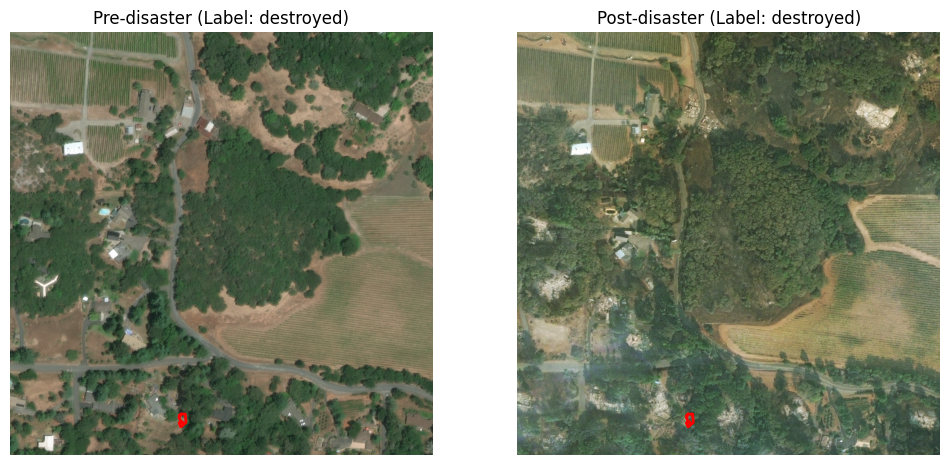

In [38]:
import random

# Pick a random row from the CSV
row = df.sample(1).iloc[0]

print("Building ID:", row["building_id"])
print("Damage class:", row["label_name"])

# Load pre/post images
pre_img = cv2.imread(row["pre_path"], cv2.IMREAD_COLOR)
post_img = cv2.imread(row["post_path"], cv2.IMREAD_COLOR)

# Convert BGR → RGB
pre_img = cv2.cvtColor(pre_img, cv2.COLOR_BGR2RGB)
post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)

# Parse polygon
poly = wkt.loads(row["polygon_wkt"])
coords = list(poly.exterior.coords)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, img, title in zip(axes, [pre_img, post_img], ["Pre-disaster", "Post-disaster"]):
    ax.imshow(img)
    xs, ys = zip(*coords)
    ax.plot(xs, ys, color="red", linewidth=2)  # polygon overlay
    ax.set_title(f"{title} (Label: {row['label_name']})")
    ax.axis("off")

plt.show()

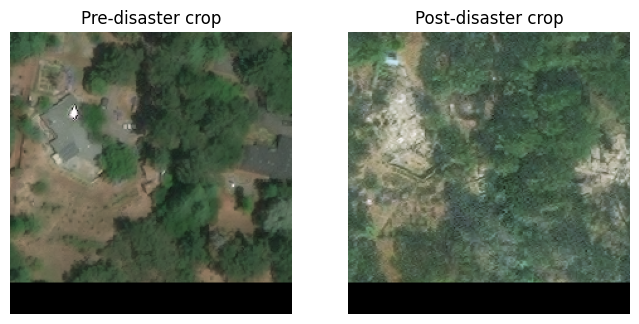

Combined crop shape (pre+post): (224, 224, 6)
Damage label: destroyed


In [39]:
import numpy as np

chip_size = 224

# Reuse the same random row as before
cx, cy = map(int, wkt.loads(row["polygon_wkt"]).centroid.coords[0])

def crop_center(img, cx, cy, size=224):
    half = size // 2
    x1, x2 = max(0, cx - half), min(img.shape[1], cx + half)
    y1, y2 = max(0, cy - half), min(img.shape[0], cy + half)
    chip = img[y1:y2, x1:x2]

    # Pad if smaller than chip_size
    chip_padded = np.zeros((size, size, 3), dtype=np.uint8)
    chip_padded[:chip.shape[0], :chip.shape[1], :] = chip

    return chip_padded

pre_chip = crop_center(pre_img, cx, cy, chip_size)
post_chip = crop_center(post_img, cx, cy, chip_size)

# Stack into 6-channel (just like your dataset class does)
combined_chip = np.concatenate([pre_chip, post_chip], axis=2)

# Show the crops
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(pre_chip)
axes[0].set_title("Pre-disaster crop")
axes[0].axis("off")

axes[1].imshow(post_chip)
axes[1].set_title("Post-disaster crop")
axes[1].axis("off")

plt.show()

print("Combined crop shape (pre+post):", combined_chip.shape)  # (224, 224, 6)
print("Damage label:", row["label_name"])